<h1 align="center"><font color="red">Evaluate RAG Pipeline using RAGAS</font></h1>

### <font color="yellow">Data Scientist.: Dr. Eddy Giusepe Chirinos Isidro</font>

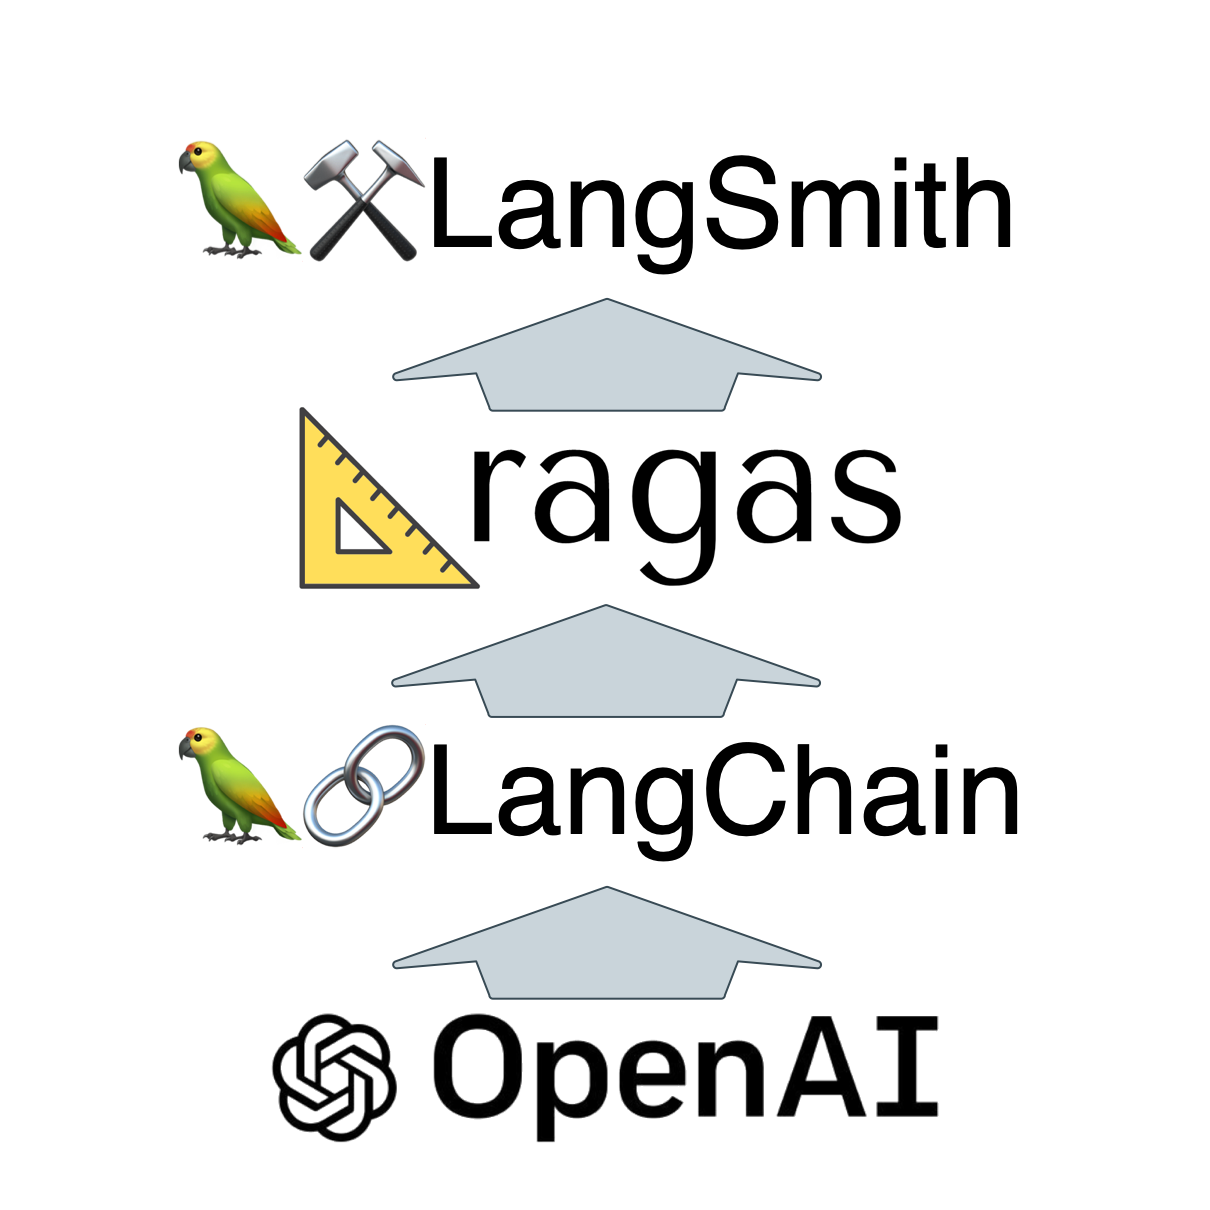

Link de estudo:


* [Evaluaing LangChain QA Chains](https://docs.ragas.io/en/latest/howtos/integrations/langchain.html#)

In [ ]:
%pip install -qU openai langchain==0.1.11  transformers tiktoken  sentence-transformers qdrant-client
%pip install ragas==0.0.22

In [2]:
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file


In [3]:
from qdrant_client import models, QdrantClient
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.document_loaders.csv_loader import CSVLoader
from langchain.vectorstores.qdrant import Qdrant
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain import PromptTemplate
#
from tqdm.auto import tqdm
from uuid import uuid4
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pandas as pd
from time import time,sleep
import openai
import tiktoken
#
import os
import json
#
import io

In [4]:
%cd /home/eddygiusepe/1_Eddy_Giusepe/3_estudando_LLMs/Large_Language_Models_LLMs/15_RAG_Evaluation/1_RAG_Evaluation


/home/eddygiusepe/1_Eddy_Giusepe/3_estudando_LLMs/Large_Language_Models_LLMs/15_RAG_Evaluation/1_RAG_Evaluation


/home/eddygiusepe/1_Eddy_Giusepe/3_estudando_LLMs/Large_Language_Models_LLMs/venv_LLMs/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [8]:
#loader = CSVLoader(file_path='./eddy_df.csv', source_column="keywords") # https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions
#data = loader.load()
from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import TextLoader


loader = DirectoryLoader(
        path='./data',
        glob='*.txt',
        loader_cls=TextLoader,
        show_progress=True,
        silent_errors=False
    )

data = loader.load()


100%|██████████| 1/1 [00:00<00:00, 1571.49it/s]


In [9]:
data

[Document(page_content='ACUMULADOR DE ENTULHO \nO que é o serviço? A acumulação de lixo/entulho é um problema de saúde pública. Você pode solicitar à Secretaria de Saúde do DF uma visita à área de acumuladores para analisar o caso e iniciar as ações para a solução do problema. \nInformações importantes do serviço: As visitas técnicas/inspeções podem ser solicitadas em qualquer uma das seguintes situações: \n• Inspeção ambiental, residencial e comercial, e em órgãos públicos para controle de vetores, peçonhentos, sinantrópicos para controle pragas urbanas de importância médica; \n• Pesquisas vetoriais técnicas aos imóveis do distrito federal, para identificar e avaliar as condições ambientais que venham a representar riscos à saúde humana; \n• Para avaliação de roedores, animais peçonhentos, sinantrópicos nos imóveis residenciais, comerciais e órgãos públicos e possíveis providencias; \n• Para avaliação e recomendações sobre pombos na residência; \n• Para avaliação sobre roedores na res

In [10]:
# embeddings = HuggingFaceEmbeddings(model_kwargs = {'device': 'cpu'},
#                                     encode_kwargs = {'normalize_embeddings': False})

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")


In [11]:
from langchain_openai import ChatOpenAI

llm=ChatOpenAI(model_name= "gpt-3.5-turbo-1106",   #'gpt-3.5-turbo-16k',
               openai_api_key=os.environ["OPENAI_API_KEY"],
               temperature=0
              )


In [12]:
metadatas = []
texts = []
for row in data:
  metadatas.append(row.metadata)
  texts.append(row.page_content)
print(len(metadatas),len(texts))


1 1


In [13]:
doc_store = Qdrant.from_texts(texts,
                              metadatas=metadatas,
                              embedding=embeddings,
                              location=":memory:",
                              prefer_grpc=True,
                              collection="adm_dig"
                             )


In [14]:
#query vector store
prompt_template = """Use as seguintes partes de contexto para responder à pergunta incluída entre três crases no final. Se você não sabe a resposta, apenas diga que não sabe, não tente inventar uma resposta.
Forneça uma resposta que seja factualmente correta e baseada nas informações recuperadas do armazenamento de vetores.
Mencione também quaisquer citações que apoiem a resposta, se houver alguma presente no contexto, fornecidas entre duas aspas duplas"" .

{context}

QUESTION:```{question}```
ANSWER:
"""
PROMPT = PromptTemplate(template=prompt_template,
                        input_variables=["context","question"]
                       )

#
chain_type_kwargs = {"prompt": PROMPT}


In [15]:
qa = RetrievalQA.from_chain_type(llm=ChatOpenAI(model_name= "gpt-3.5-turbo-1106",  #'gpt-3.5-turbo-16k',
                                                  openai_api_key=os.environ["OPENAI_API_KEY"],
                                                  temperature=0),
                                  chain_type="stuff",
                                  chain_type_kwargs={"prompt": PROMPT},
                                  retriever=doc_store.as_retriever(search_kwargs={"k": 3}),
                                  return_source_documents=True
                                  )

#
questions = input("Forneça a sua query aqui 🧐:")
print(questions)
result = qa(questions)


Qual é o beneficio da limpeza de Grelha?


/home/eddygiusepe/1_Eddy_Giusepe/3_estudando_LLMs/Large_Language_Models_LLMs/venv_LLMs/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


In [16]:
print(result.keys())

dict_keys(['query', 'result', 'source_documents'])


In [17]:
print(result['query'])

Qual é o beneficio da limpeza de Grelha?


In [18]:
print(result['result'])

A limpeza de grelha é importante para garantir o escoamento adequado da água da chuva, prevenindo alagamentos e enchentes. Além disso, a limpeza das grelhas contribui para o controle de vetores e pragas urbanas, evitando a proliferação de doenças. "O serviço de limpeza da boca de lobo / bueiro é realizada em 2 etapas e por equipes diferentes: A 1ª equipe realiza a limpeza e coloca o resíduo perto do bueiro; A 2ª equipe, em um outro momento, recolhe o material."


In [19]:
result["source_documents"]

[Document(page_content='ACUMULADOR DE ENTULHO \nO que é o serviço? A acumulação de lixo/entulho é um problema de saúde pública. Você pode solicitar à Secretaria de Saúde do DF uma visita à área de acumuladores para analisar o caso e iniciar as ações para a solução do problema. \nInformações importantes do serviço: As visitas técnicas/inspeções podem ser solicitadas em qualquer uma das seguintes situações: \n• Inspeção ambiental, residencial e comercial, e em órgãos públicos para controle de vetores, peçonhentos, sinantrópicos para controle pragas urbanas de importância médica; \n• Pesquisas vetoriais técnicas aos imóveis do distrito federal, para identificar e avaliar as condições ambientais que venham a representar riscos à saúde humana; \n• Para avaliação de roedores, animais peçonhentos, sinantrópicos nos imóveis residenciais, comerciais e órgãos públicos e possíveis providencias; \n• Para avaliação e recomendações sobre pombos na residência; \n• Para avaliação sobre roedores na res

In [20]:
print(result['source_documents'][0].page_content)

ACUMULADOR DE ENTULHO 
O que é o serviço? A acumulação de lixo/entulho é um problema de saúde pública. Você pode solicitar à Secretaria de Saúde do DF uma visita à área de acumuladores para analisar o caso e iniciar as ações para a solução do problema. 
Informações importantes do serviço: As visitas técnicas/inspeções podem ser solicitadas em qualquer uma das seguintes situações: 
• Inspeção ambiental, residencial e comercial, e em órgãos públicos para controle de vetores, peçonhentos, sinantrópicos para controle pragas urbanas de importância médica; 
• Pesquisas vetoriais técnicas aos imóveis do distrito federal, para identificar e avaliar as condições ambientais que venham a representar riscos à saúde humana; 
• Para avaliação de roedores, animais peçonhentos, sinantrópicos nos imóveis residenciais, comerciais e órgãos públicos e possíveis providencias; 
• Para avaliação e recomendações sobre pombos na residência; 
• Para avaliação sobre roedores na residência e possíveis providência

In [21]:
# Para avaliar o sistema de Q&A, geramos algumas perguntas e respostas relevantes:
eval_questions = [
    "O que é Acumulador de entulho?",
    "O que é o serviço de limpeza de Grelha?",
    "Como solicitar o serviço de implantação, manutenção e/ou reforma de ciclovias do DF?",
    "Prazo pra prestação do serviço de criação, revitalização, remoção ou mudança Faixa de pedestre / Sinalização Viária?",
    "Prazo pra prestação do serviço de Iluminação pública?",
    "O que é Instalação de Parquinhos infantis?",
]

eval_answers = [
    "Acumulador de entulho é um problema de saúde pública que pode ser solicitado à Secretaria de Saúde do DF para análise e ações de solução do problema.",
    "O serviço de limpeza de grelha é a remoção de resíduos e sujeira das grelhas localizadas em vias públicas, garantindo o bom funcionamento do sistema de drenagem e evitando alagamentos.", 
    "Você pode solicitar por meio do Portal de Serviços do GDF (https://servicos.df.gov.br/categorias?categoria=ADMINISTRA%C3%87%C3%83O%20REGIONAL%2024h&persona=Cidad%C3%A3o#servicos), através do telefone 156 ou pelo aplicativo eGDF, que você está utilizando. Para solicitar, clique no ícone de ""casinha"", na barra inferior, em seguida, clique no botão ""informe aqui"", lá você terá acesso a todos os serviços de forma simples e prática.",
    "O prazo é superior à 30 (trinta) dias podendo variar de acordo com a demanda. Ver detalhamento dos prazos na carta de serviço do órgão.",
    "Os prazos para as ordens de serviço variam de acordo com a demanda.",
    "É um carro vermelho",  #"É a instalação e manutenção dos equipamentos referentes aos parquinhos infantis em área pública.",
]

examples = [
    {"query": q, "ground_truths": [eval_answers[i]]}
    for i, q in enumerate(eval_questions)]




examples


[{'query': 'O que é Acumulador de entulho?',
  'ground_truths': ['Acumulador de entulho é um problema de saúde pública que pode ser solicitado à Secretaria de Saúde do DF para análise e ações de solução do problema.']},
 {'query': 'O que é o serviço de limpeza de Grelha?',
  'ground_truths': ['O serviço de limpeza de grelha é a remoção de resíduos e sujeira das grelhas localizadas em vias públicas, garantindo o bom funcionamento do sistema de drenagem e evitando alagamentos.']},
 {'query': 'Como solicitar o serviço de implantação, manutenção e/ou reforma de ciclovias do DF?',
  'ground_truths': ['Você pode solicitar por meio do Portal de Serviços do GDF (https://servicos.df.gov.br/categorias?categoria=ADMINISTRA%C3%87%C3%83O%20REGIONAL%2024h&persona=Cidad%C3%A3o#servicos), através do telefone 156 ou pelo aplicativo eGDF, que você está utilizando. Para solicitar, clique no ícone de casinha, na barra inferior, em seguida, clique no botão informe aqui, lá você terá acesso a todos os servi

# <font color="pink">Import RAGAS Metrics</font>

[Link Ragas](https://docs.ragas.io/en/latest/howtos/integrations/langchain.html#)

In [22]:
from ragas.langchain.evalchain import RagasEvaluatorChain   # https://github.com/explodinggradients/ragas/issues/571

from ragas.metrics import (
    faithfulness,
    context_recall,
    answer_relevancy,
    context_relevancy,
)

# Criamos cadeias de avaliação:
faithfulness_chain = RagasEvaluatorChain(metric=faithfulness)
context_recall_chain = RagasEvaluatorChain(metric=context_recall)
answer_rel_chain = RagasEvaluatorChain(metric=answer_relevancy)
context_rel_chain = RagasEvaluatorChain(metric=context_relevancy)



In [23]:
result = qa(examples[0])
print(result["result"])


O serviço de Acumulador de Entulho é a solicitação à Secretaria de Saúde do DF para analisar e iniciar ações para solucionar o problema de acumulação de lixo/entulho, que é um problema de saúde pública. As visitas técnicas/inspeções podem ser solicitadas em diversas situações, como inspeção ambiental, residencial e comercial, controle de vetores, peçonhentos, sinantrópicos para controle de pragas urbanas de importância médica, entre outras. O prazo para prestação do serviço é de 7 (sete) dias, podendo variar de acordo com a demanda. A solicitação pode ser feita através do Portal de Serviços do GDF, pelo telefone 156 ou pelo aplicativo eGDF. Fonte: "https://www.saude.df.gov.br/documents/37101/0/Carta-Servicos-da-Saude_Cidadao-1.pdf/764377b8-3235-2fb9-b918-2dd49d1d2d9e?t=1658771250421"


In [24]:
result

{'query': 'O que é Acumulador de entulho?',
 'ground_truths': ['Acumulador de entulho é um problema de saúde pública que pode ser solicitado à Secretaria de Saúde do DF para análise e ações de solução do problema.'],
 'result': 'O serviço de Acumulador de Entulho é a solicitação à Secretaria de Saúde do DF para analisar e iniciar ações para solucionar o problema de acumulação de lixo/entulho, que é um problema de saúde pública. As visitas técnicas/inspeções podem ser solicitadas em diversas situações, como inspeção ambiental, residencial e comercial, controle de vetores, peçonhentos, sinantrópicos para controle de pragas urbanas de importância médica, entre outras. O prazo para prestação do serviço é de 7 (sete) dias, podendo variar de acordo com a demanda. A solicitação pode ser feita através do Portal de Serviços do GDF, pelo telefone 156 ou pelo aplicativo eGDF. Fonte: "https://www.saude.df.gov.br/documents/37101/0/Carta-Servicos-da-Saude_Cidadao-1.pdf/764377b8-3235-2fb9-b918-2dd49d

# <font color="gree">Faithfulness Score</font>

In [39]:
eval_result = faithfulness_chain(result)

eval_result

{'query': 'O que é Acumulador de entulho?',
 'ground_truths': ['Acumulador de entulho é um problema de saúde pública que pode ser solicitado à Secretaria de Saúde do DF para análise e ações de solução do problema.'],
 'result': 'O serviço de Acumulador de Entulho é a solicitação à Secretaria de Saúde do DF para analisar e iniciar ações para solucionar o problema de acumulação de lixo/entulho, que é um problema de saúde pública. As visitas técnicas/inspeções podem ser solicitadas em diversas situações, como inspeção ambiental, residencial e comercial, controle de vetores, peçonhentos, sinantrópicos para controle de pragas urbanas de importância médica, entre outras. O prazo para prestação do serviço é de 7 (sete) dias, podendo variar de acordo com a demanda. A solicitação pode ser feita através do Portal de Serviços do GDF, pelo telefone 156 ou pelo aplicativo eGDF. Fonte: "https://www.saude.df.gov.br/documents/37101/0/Carta-Servicos-da-Saude_Cidadao-1.pdf/764377b8-3235-2fb9-b918-2dd49d

In [40]:
#eval_result = faithfulness_chain(result)
print(eval_result["faithfulness_score"])


0.6666666666666666


In [ ]:
fake_result = result.copy()
fake_result["result"] = "Vamos para a praia."
eval_result = faithfulness_chain(fake_result)
eval_result["faithfulness_score"]

# <font color="gree">Context Recall Score</font>

In [30]:
eval_result = context_recall_chain(result)

eval_result

{'query': 'O que é Acumulador de entulho?',
 'ground_truths': ['Acumulador de entulho é um problema de saúde pública que pode ser solicitado à Secretaria de Saúde do DF para análise e ações de solução do problema.'],
 'result': 'O serviço de Acumulador de Entulho é a solicitação à Secretaria de Saúde do DF para analisar e iniciar ações para solucionar o problema de acumulação de lixo/entulho, que é um problema de saúde pública. As visitas técnicas/inspeções podem ser solicitadas em diversas situações, como inspeção ambiental, residencial e comercial, controle de vetores, peçonhentos, sinantrópicos para controle de pragas urbanas de importância médica, entre outras. O prazo para prestação do serviço é de 7 (sete) dias, podendo variar de acordo com a demanda. A solicitação pode ser feita através do Portal de Serviços do GDF, pelo telefone 156 ou pelo aplicativo eGDF. Fonte: "https://www.saude.df.gov.br/documents/37101/0/Carta-Servicos-da-Saude_Cidadao-1.pdf/764377b8-3235-2fb9-b918-2dd49d

In [31]:
#eval_result = context_recall_chain(result)
print(eval_result["context_recall_score"])


1.0


In [32]:
from langchain.schema import Document

fake_result = result.copy()
fake_result["source_documents"] = [Document(page_content="Eu sou futbolista")]
eval_result = context_recall_chain(fake_result)
eval_result["context_recall_score"]


0.0

In [33]:
result_1 = qa(examples[1])
eval_result_1 = context_recall_chain(result_1)
eval_result_1

{'query': 'O que é o serviço de limpeza de Grelha?',
 'ground_truths': ['O serviço de limpeza de grelha é a remoção de resíduos e sujeira das grelhas localizadas em vias públicas, garantindo o bom funcionamento do sistema de drenagem e evitando alagamentos.'],
 'result': 'O serviço de limpeza de grelha é a execução da limpeza de bueiros / boca de lobos / grelha, conforme mencionado no contexto. Esse serviço é realizado em duas etapas por equipes diferentes, sendo a primeira equipe responsável pela limpeza e colocação do resíduo perto do bueiro, e a segunda equipe encarregada de recolher o material. Esse serviço pode ser solicitado em áreas públicas e o prazo para prestação do serviço é de até 60 (sessenta) dias, podendo variar de acordo com a demanda. Essas informações podem ser encontradas no contexto fornecido.',
 'source_documents': [Document(page_content='ACUMULADOR DE ENTULHO \nO que é o serviço? A acumulação de lixo/entulho é um problema de saúde pública. Você pode solicitar à Se

In [34]:
result_2 = qa(examples[2])
eval_result_2 = context_recall_chain(result_2)
eval_result_2

{'query': 'Como solicitar o serviço de implantação, manutenção e/ou reforma de ciclovias do DF?',
 'ground_truths': ['Você pode solicitar por meio do Portal de Serviços do GDF (https://servicos.df.gov.br/categorias?categoria=ADMINISTRA%C3%87%C3%83O%20REGIONAL%2024h&persona=Cidad%C3%A3o#servicos), através do telefone 156 ou pelo aplicativo eGDF, que você está utilizando. Para solicitar, clique no ícone de casinha, na barra inferior, em seguida, clique no botão informe aqui, lá você terá acesso a todos os serviços de forma simples e prática.'],
 'result': 'Você pode solicitar o serviço de implantação, manutenção e/ou reforma de ciclovias do DF por meio do Portal de Serviços do GDF, através do telefone 156 ou pelo aplicativo eGDF. Para solicitar, clique no ícone de "casinha", na barra inferior, em seguida, clique no botão "informe aqui", lá você terá acesso a todos os serviços de forma simples e prática.',
 'source_documents': [Document(page_content='ACUMULADOR DE ENTULHO \nO que é o serv

In [35]:
result_3 = qa(examples[3])
eval_result_3 = context_recall_chain(result_3)
eval_result_3

{'query': 'Prazo pra prestação do serviço de criação, revitalização, remoção ou mudança Faixa de pedestre / Sinalização Viária?',
 'ground_truths': ['O prazo é superior à 30 (trinta) dias podendo variar de acordo com a demanda. Ver detalhamento dos prazos na carta de serviço do órgão.'],
 'result': 'O prazo para prestação do serviço de criação, revitalização, remoção ou mudança de faixa de pedestre/sinalização viária é superior a 30 (trinta) dias, podendo variar de acordo com a demanda. Esta informação pode ser confirmada no detalhamento dos prazos na carta de serviço do órgão responsável. Fonte: "PRAZO PARA PRESTAÇÃO DO SERVIÇO: O prazo é superior à 30 (trinta) dias podendo variar de acordo com a demanda. Ver detalhamento dos prazos na carta de serviço do órgão."',
 'source_documents': [Document(page_content='ACUMULADOR DE ENTULHO \nO que é o serviço? A acumulação de lixo/entulho é um problema de saúde pública. Você pode solicitar à Secretaria de Saúde do DF uma visita à área de acumu

In [36]:
result_4 = qa(examples[4])
eval_result_4 = context_recall_chain(result_4)
eval_result_4

{'query': 'Prazo pra prestação do serviço de Iluminação pública?',
 'ground_truths': ['Os prazos para as ordens de serviço variam de acordo com a demanda.'],
 'result': 'O prazo para prestação do serviço de Iluminação Pública varia de acordo com a demanda, conforme indicado no texto: "Os prazos para as ordens de serviço variam de acordo com a demanda."',
 'source_documents': [Document(page_content='ACUMULADOR DE ENTULHO \nO que é o serviço? A acumulação de lixo/entulho é um problema de saúde pública. Você pode solicitar à Secretaria de Saúde do DF uma visita à área de acumuladores para analisar o caso e iniciar as ações para a solução do problema. \nInformações importantes do serviço: As visitas técnicas/inspeções podem ser solicitadas em qualquer uma das seguintes situações: \n• Inspeção ambiental, residencial e comercial, e em órgãos públicos para controle de vetores, peçonhentos, sinantrópicos para controle pragas urbanas de importância médica; \n• Pesquisas vetoriais técnicas aos i

In [37]:
result_5 = qa(examples[5])
eval_result_5 = context_recall_chain(result_5)
eval_result_5

{'query': 'O que é Instalação de Parquinhos infantis?',
 'ground_truths': ['É um carro vermelho'],
 'result': 'Não sei.',
 'source_documents': [Document(page_content='ACUMULADOR DE ENTULHO \nO que é o serviço? A acumulação de lixo/entulho é um problema de saúde pública. Você pode solicitar à Secretaria de Saúde do DF uma visita à área de acumuladores para analisar o caso e iniciar as ações para a solução do problema. \nInformações importantes do serviço: As visitas técnicas/inspeções podem ser solicitadas em qualquer uma das seguintes situações: \n• Inspeção ambiental, residencial e comercial, e em órgãos públicos para controle de vetores, peçonhentos, sinantrópicos para controle pragas urbanas de importância médica; \n• Pesquisas vetoriais técnicas aos imóveis do distrito federal, para identificar e avaliar as condições ambientais que venham a representar riscos à saúde humana; \n• Para avaliação de roedores, animais peçonhentos, sinantrópicos nos imóveis residenciais, comerciais e ór

# <font color="gree">Answer relevancy score</font>

In [ ]:
eval_result = answer_rel_chain(result)

eval_result

In [ ]:
#eval_result = answer_rel_chain(result)
print(eval_result['answer_relevancy_score'])


# <font color="gree">Context relevancy score</font>

In [ ]:
eval_result = context_rel_chain(result)

eval_result

In [ ]:
eval_result = context_rel_chain(result)
print(eval_result['context_relevancy_score'])

# <font color="pink">Avaliando uma lista de exemplos</font>

In [25]:
# Vamos usar cores:
GREEN = '\033[92m'
RED = '\033[91m'
RESET = '\033[0m' # Restabelecer a cor

In [26]:
# Executamos as queries em BATCH para maior eficiência:
predictions = qa.batch(examples)

# Avaliando a faithfulness:
print(f"{GREEN}Avaliando a faithfulness ...{RESET}")
Fidelidade = faithfulness_chain.evaluate(examples, predictions)

Fidelidade


Avaliando a faithfulness ...


100%|██████████| 1/1 [00:14<00:00, 14.60s/it]


[{'faithfulness_score': 1.0},
 {'faithfulness_score': 1.0},
 {'faithfulness_score': 0.3333333333333333},
 {'faithfulness_score': 0.6666666666666666},
 {'faithfulness_score': 0.6666666666666666},
 {'faithfulness_score': 1.0}]

In [27]:
predictions = qa.batch(examples)
# Avaliando a recuperação do contexto:
print(f"{GREEN}Avaliando a context recall ...{RESET}")
context = context_recall_chain.evaluate(examples, predictions) 

context


Avaliando a context recall ...


0it [00:00, ?it/s]


[]

In [28]:
# Avaliando a relevância da resposta:
print(f"{GREEN}Avaliando a answer relevancy ...{RESET}")
resposta_relevante = answer_rel_chain.evaluate(examples, predictions)
resposta_relevante

Avaliando a answer relevancy ...


100%|██████████| 1/1 [00:12<00:00, 12.80s/it]


[{'answer_relevancy_score': 0.7342928319760249},
 {'answer_relevancy_score': 0.7470820898664104},
 {'answer_relevancy_score': 0.7658402461841153},
 {'answer_relevancy_score': 0.7836350208305354},
 {'answer_relevancy_score': 0.7856476936799989},
 {'answer_relevancy_score': 0.7504477448090657}]

In [29]:
# Avaliando a relevância do contexto:
print(f"{GREEN}Avaliando a context relevancy ...{RESET}")
contexto_relevante = context_rel_chain.evaluate(examples, predictions)
contexto_relevante


Avaliando a context relevancy ...


100%|██████████| 1/1 [00:06<00:00,  6.74s/it]


[{'context_relevancy_score': 0.014319809069212411},
 {'context_relevancy_score': 0.002386634844868735},
 {'context_relevancy_score': 0.00954653937947494},
 {'context_relevancy_score': 0.01909307875894988},
 {'context_relevancy_score': 0.00954653937947494},
 {'context_relevancy_score': 0.00477326968973747}]